# Modelo de Severidad - Contenidos

## Objetivo
Predecir la **severidad promedio** (monto promedio por siniestro) de la cobertura de Contenidos para asegurados que ya tuvieron siniestros.

## Pipeline
1. **Fase 1**: Preprocesamiento + GLM Lognormal + Selección Backward
2. **Fase 2**: LazyPredict con variables seleccionadas
3. **Fase 3**: Evaluación con MAE y GINI

**Dataset**: Solo registros siniestrados de Contenidos

## 1. Imports y Configuración

In [31]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Métricas
from sklearn.metrics import mean_absolute_error, r2_score

# LazyPredict
from lazypredict.Supervised import LazyRegressor

# Selección de variables con GLM
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Carga y Preparación de Datos

In [32]:
# Cargar datos de siniestrados
df = pd.read_csv("../data/processed/contenidos_siniestrados.csv")

print(f"Dataset original: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Dataset original: (743, 15)

Columnas: ['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto', 'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto', 'Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto', 'Contenidos_siniestros_num', 'Contenidos_siniestros_monto']


,año_cursado,estudios_area,calif_promedio,2_o_mas_inquilinos,distancia_al_campus,genero,extintor_incendios,Gastos_Adicionales_siniestros_num,Gastos_Adicionales_siniestros_monto,Gastos_Medicos_RC_siniestros_num,Gastos_Medicos_RC_siniestros_monto,Resp_Civil_siniestros_num,Resp_Civil_siniestros_monto,Contenidos_siniestros_num,Contenidos_siniestros_monto
0,2do año,Otro,2.45,No,10.08,Femenino,Si,0.00,0.00,0.00,0.00,0.00,0.00,1.00,990.60
1,4to año,Ciencias,4.69,Si,0.00,Masculino,Si,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1172.94
2,2do año,Administracion,6.46,Si,0.00,Masculino,Si,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2106.47
3,3er año,Ciencias,8.02,Si,9.15,Femenino,Si,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1433.56
4,4to año,Ciencias,8.10,Si,0.00,Femenino,No,0.00,0.00,0.00,0.00,0.00,0.00,1.00,500.61



Dataset preparado: (743, 8)

Estadísticas de severidad:
count    743.00
mean    1009.82
std      835.74
min       27.09
25%      448.85
50%      790.19
75%     1288.34
max     5863.11
Name: severidad, dtype: float64


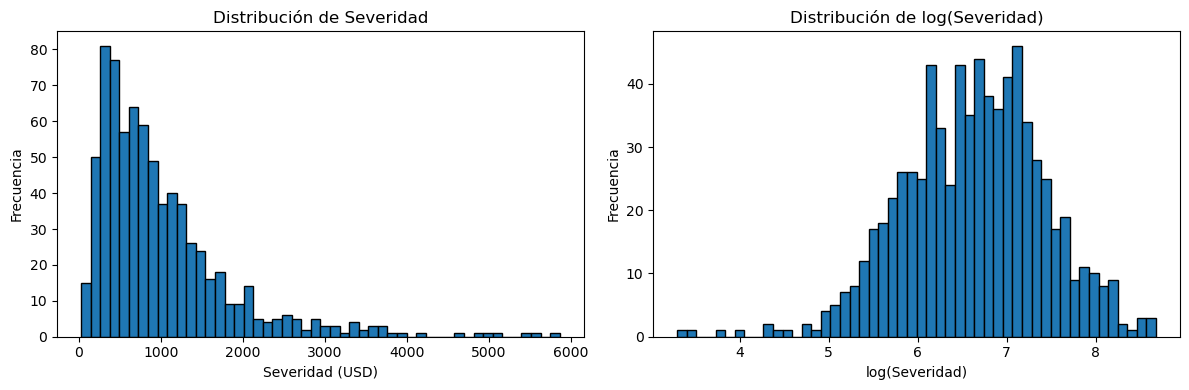

In [33]:
# Crear variable objetivo: Severidad = Monto / Número de siniestros
df['severidad'] = df['Contenidos_siniestros_monto'] / df['Contenidos_siniestros_num']

# Eliminar columnas originales de monto y número
df = df.drop(['Contenidos_siniestros_monto', 'Contenidos_siniestros_num'], axis=1)

# Eliminar también las otras coberturas (no se usan para este modelo)
columnas_otras_coberturas = [
    'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto',
    'Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto',
    'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto'
]
df = df.drop(columnas_otras_coberturas, axis=1)

print(f"\nDataset preparado: {df.shape}")
print(f"\nEstadísticas de severidad:")
print(df['severidad'].describe())

# Visualizar distribución de severidad
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['severidad'], bins=50, edgecolor='black')
plt.xlabel('Severidad (USD)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Severidad')

plt.subplot(1, 2, 2)
plt.hist(np.log(df['severidad']), bins=50, edgecolor='black')
plt.xlabel('log(Severidad)')
plt.ylabel('Frecuencia')
plt.title('Distribución de log(Severidad)')

plt.tight_layout()
plt.show()

## 3. Identificación de Variables

In [34]:
# Identificar tipos de variables
numeric_features = ['calif_promedio', 'distancia_al_campus']
categorical_features = ['año_cursado', 'estudios_area', '2_o_mas_inquilinos', 'genero', 'extintor_incendios']

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)
print(f"\nTotal features: {len(numeric_features) + len(categorical_features)}")

# Verificar valores faltantes
print(f"\nValores faltantes:\n{df.isnull().sum()}")

Variables numéricas: ['calif_promedio', 'distancia_al_campus']
Variables categóricas: ['año_cursado', 'estudios_area', '2_o_mas_inquilinos', 'genero', 'extintor_incendios']

Total features: 7

Valores faltantes:
año_cursado            0
estudios_area          0
calif_promedio         0
2_o_mas_inquilinos     0
distancia_al_campus    0
genero                 0
extintor_incendios     0
severidad              0
dtype: int64


## 4. Preprocesamiento y Split de Datos

In [35]:
# Separar features y target
X = df.drop('severidad', axis=1)
y = df['severidad']

# Split train/test 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Train set: {X_train.shape} | Severidad promedio: ${y_train.mean():.2f}")
print(f"Test set:  {X_test.shape} | Severidad promedio: ${y_test.mean():.2f}")

Train set: (594, 7) | Severidad promedio: $1013.30
Test set:  (149, 7) | Severidad promedio: $995.94


In [36]:
# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# Ajustar y transformar datos
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtener nombres de features después de one-hot encoding
feature_names_num = numeric_features
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(feature_names_num) + list(feature_names_cat)

# Convertir a DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"\nFeatures después de preprocesamiento: {len(feature_names)}")
print(f"Shape X_train: {X_train_df.shape}")
print(f"Shape X_test: {X_test_df.shape}")


Features después de preprocesamiento: 14
Shape X_train: (594, 14)
Shape X_test: (149, 14)


## 5. Fase 1 - GLM Lognormal con Selección Backward de Variables

In [37]:
# Modelo GLM con distribución Gamma (lognormal) para referencia
X_train_const = sm.add_constant(X_train_df)

# GLM con familia Gamma y link log (apropiado para severidad)
glm_full = sm.GLM(y_train, X_train_const, family=Gamma(link=sm.families.links.Log()))
result_full = glm_full.fit()

print("=" * 80)
print("MODELO GLM LOGNORMAL COMPLETO (todas las variables)")
print("=" * 80)
print(result_full.summary())

MODELO GLM LOGNORMAL COMPLETO (todas las variables)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:                  594
Model:                            GLM   Df Residuals:                      579
Model Family:                   Gamma   Df Model:                           14
Link Function:                    Log   Scale:                         0.40021
Method:                          IRLS   Log-Likelihood:                -4519.8
Date:                Fri, 10 Oct 2025   Deviance:                       230.77
Time:                        01:05:33   Pearson chi2:                     232.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3848
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [38]:
# Selección Backward basada en p-valores
def backward_elimination_glm(X, y, significance_level=0.1):
    """
    Realiza selección backward de variables basada en p-valores del GLM Lognormal.
    """
    features = list(X.columns)
    
    while True:
        X_const = sm.add_constant(X[features])
        model = sm.GLM(y, X_const, family=Gamma(link=sm.families.links.Log())).fit()
        p_values = model.pvalues.iloc[1:]  # Excluir constante
        max_p_value = p_values.max()
        
        if max_p_value <= significance_level:
            break
            
        feature_to_remove = p_values.idxmax()
        features.remove(feature_to_remove)
        print(f"Eliminando: {feature_to_remove} (p-valor: {max_p_value:.4f})")
    
    return features, model

print("=" * 80)
print("SELECCIÓN BACKWARD DE VARIABLES (α = 0.1)")
print("=" * 80)
print()

selected_features, glm_backward = backward_elimination_glm(X_train_df, y_train, significance_level=0.1)

print()
print("=" * 80)
print(f"VARIABLES SELECCIONADAS: {len(selected_features)}")
print("=" * 80)
for feat in selected_features:
    print(f"  • {feat}")
print()
print(glm_backward.summary())

SELECCIÓN BACKWARD DE VARIABLES (α = 0.1)

Eliminando: estudios_area_Otro (p-valor: 0.8339)
Eliminando: genero_No respuesta (p-valor: 0.7131)
Eliminando: estudios_area_Ciencias (p-valor: 0.5589)
Eliminando: genero_Otro (p-valor: 0.5247)
Eliminando: calif_promedio (p-valor: 0.3500)
Eliminando: año_cursado_2do año (p-valor: 0.2316)
Eliminando: genero_Masculino (p-valor: 0.1165)
Eliminando: estudios_area_Humanidades (p-valor: 0.1119)

VARIABLES SELECCIONADAS: 6
  • distancia_al_campus
  • año_cursado_3er año
  • año_cursado_4to año
  • año_cursado_posgrado
  • 2_o_mas_inquilinos_Si
  • extintor_incendios_Si

                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:                  594
Model:                            GLM   Df Residuals:                      587
Model Family:                   Gamma   Df Model:                            6
Link Function:                    Log   Scale:                         

In [39]:
# Expandir variables categóricas completas
def expand_categorical_features(selected_features, all_feature_names, categorical_features):
    """
    Si se seleccionó un nivel de una variable categórica, incluir todos sus niveles.
    """
    selected_cat_vars = set()
    for feat in selected_features:
        for cat_var in categorical_features:
            if feat.startswith(cat_var + '_'):
                selected_cat_vars.add(cat_var)
                break
    
    # Incluir variables numéricas seleccionadas
    final_features = []
    for feat in selected_features:
        is_categorical = any(feat.startswith(cat_var + '_') for cat_var in categorical_features)
        if not is_categorical:
            final_features.append(feat)
    
    # Agregar todos los niveles de las categóricas seleccionadas
    for feat in all_feature_names:
        for cat_var in selected_cat_vars:
            if feat.startswith(cat_var + '_') and feat not in final_features:
                final_features.append(feat)
                break
    
    return sorted(final_features)

final_selected_features = expand_categorical_features(selected_features, feature_names, categorical_features)

print("=" * 80)
print("FEATURES FINALES (con todos los niveles de categóricas)")
print("=" * 80)
print(f"\nTotal features: {len(final_selected_features)}")
print("\nFeatures seleccionadas:")
for feat in final_selected_features:
    indicator = "✓" if feat in selected_features else "+"
    print(f"  {indicator} {feat}")

X_train_selected = X_train_df[final_selected_features]
X_test_selected = X_test_df[final_selected_features]

print(f"\nShape final - Train: {X_train_selected.shape} | Test: {X_test_selected.shape}")

FEATURES FINALES (con todos los niveles de categóricas)

Total features: 7

Features seleccionadas:
  ✓ 2_o_mas_inquilinos_Si
  + año_cursado_2do año
  ✓ año_cursado_3er año
  ✓ año_cursado_4to año
  ✓ año_cursado_posgrado
  ✓ distancia_al_campus
  ✓ extintor_incendios_Si

Shape final - Train: (594, 7) | Test: (149, 7)


## 6. Fase 2 - LazyPredict para Identificar Mejores Regresores

In [40]:
# Ejecutar LazyPredict
print("=" * 80)
print("EJECUTANDO LAZYPREDICT (REGRESIÓN)")
print("=" * 80)
print(f"\nDataset: {X_train_selected.shape[0]} muestras, {X_train_selected.shape[1]} features")
print("Esto puede tomar varios minutos...\n")

reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True, random_state=42)
models, predictions = reg.fit(X_train_selected, X_test_selected, y_train, y_test)

print("\n" + "=" * 80)
print("RESULTADOS DE LAZYPREDICT")
print("=" * 80)
print()
print(models)

EJECUTANDO LAZYPREDICT (REGRESIÓN)

Dataset: 594 muestras, 7 features
Esto puede tomar varios minutos...



  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 7
[LightGBM] [Info] Start training from score 1013.304905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

## 7. Cálculo de Métricas: MAE y GINI

In [41]:
# Función para calcular coeficiente de Gini
def gini_coefficient(y_true, y_pred):
    """
    Calcula el coeficiente de Gini basado en ordenamiento de predicciones.
    Gini = 2 * AUC - 1, donde AUC se calcula como área bajo la curva Lorenz.
    """
    # Ordenar por predicciones
    sorted_indices = np.argsort(y_pred)
    y_true_sorted = np.array(y_true)[sorted_indices]
    
    # Calcular proporciones acumuladas
    n = len(y_true_sorted)
    cumsum_true = np.cumsum(y_true_sorted)
    sum_true = cumsum_true[-1]
    
    # Evitar división por cero
    if sum_true == 0:
        return 0.0
    
    # Calcular Gini
    gini = (2 * np.sum((np.arange(n) + 1) * y_true_sorted) / (n * sum_true)) - (n + 1) / n
    return gini

print("✓ Función de cálculo de Gini definida")

✓ Función de cálculo de Gini definida


In [42]:
# Calcular MAE y GINI para cada modelo
print("=" * 80)
print("MÉTRICAS: MAE Y GINI")
print("=" * 80)
print()

resultados = []

for model_name in models.index:
    # Obtener predicciones del modelo
    y_pred = predictions[model_name].values
    
    # Calcular MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calcular GINI
    gini = gini_coefficient(y_test, y_pred)
    
    # Obtener R² del LazyPredict
    r2 = models.loc[model_name, 'R-Squared']
    
    resultados.append({
        'Modelo': model_name,
        'MAE': mae,
        'GINI': gini,
        'R²': r2
    })
    
    print(f"\n{model_name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  GINI: {gini:.4f}")
    print(f"  R²:   {r2:.4f}")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar por MAE (menor es mejor)
df_resultados_sorted = df_resultados.sort_values('MAE')

print("\n" + "=" * 80)
print("RESUMEN ORDENADO POR MAE (menor es mejor)")
print("=" * 80)
print()
print(df_resultados_sorted.to_string(index=False))

print("\n" + "=" * 80)
print("TOP 5 MODELOS POR MAE")
print("=" * 80)
print()
print(df_resultados_sorted.head(5).to_string(index=False))

MÉTRICAS: MAE Y GINI


HistGradientBoostingRegressor:
  MAE:  $508.74
  GINI: 0.2402
  R²:   0.2676

AdaBoostRegressor:
  MAE:  $522.13
  GINI: 0.2371
  R²:   0.2669

PoissonRegressor:
  MAE:  $516.45
  GINI: 0.2379
  R²:   0.2567

BayesianRidge:
  MAE:  $517.52
  GINI: 0.2390
  R²:   0.2564

RidgeCV:
  MAE:  $517.77
  GINI: 0.2390
  R²:   0.2560

LarsCV:
  MAE:  $518.23
  GINI: 0.2380
  R²:   0.2551

LassoLarsCV:
  MAE:  $518.23
  GINI: 0.2380
  R²:   0.2551

LassoCV:
  MAE:  $518.32
  GINI: 0.2380
  R²:   0.2549

LassoLarsIC:
  MAE:  $518.32
  GINI: 0.2380
  R²:   0.2548

SGDRegressor:
  MAE:  $518.36
  GINI: 0.2386
  R²:   0.2547

LassoLars:
  MAE:  $518.50
  GINI: 0.2391
  R²:   0.2547

Lasso:
  MAE:  $518.50
  GINI: 0.2391
  R²:   0.2547

Ridge:
  MAE:  $518.60
  GINI: 0.2393
  R²:   0.2547

Lars:
  MAE:  $518.69
  GINI: 0.2395
  R²:   0.2545

LinearRegression:
  MAE:  $518.69
  GINI: 0.2393
  R²:   0.2545

TransformedTargetRegressor:
  MAE:  $518.69
  GINI: 0.2393
  R²:   0.2545


---
## FASE 2: Optimización de Hiperparámetros con GridSearchCV

In [43]:
# Seleccionar modelos para optimización (Top 5 por MAE)
modelos_a_optimizar = df_resultados_sorted.head(5)['Modelo'].tolist()

print("=" * 80)
print("MODELOS SELECCIONADOS PARA OPTIMIZACIÓN (Top 5 por MAE)")
print("=" * 80)
print()
for i, modelo in enumerate(modelos_a_optimizar, 1):
    mae = df_resultados_sorted[df_resultados_sorted['Modelo'] == modelo]['MAE'].values[0]
    gini = df_resultados_sorted[df_resultados_sorted['Modelo'] == modelo]['GINI'].values[0]
    r2 = df_resultados_sorted[df_resultados_sorted['Modelo'] == modelo]['R²'].values[0]
    print(f"{i}. {modelo}")
    print(f"   MAE: ${mae:,.2f} | GINI: {gini:.4f} | R²: {r2:.4f}")

MODELOS SELECCIONADOS PARA OPTIMIZACIÓN (Top 5 por MAE)

1. HuberRegressor
   MAE: $505.45 | GINI: 0.2375 | R²: 0.2496
2. PassiveAggressiveRegressor
   MAE: $507.30 | GINI: 0.2363 | R²: 0.2364
3. HistGradientBoostingRegressor
   MAE: $508.74 | GINI: 0.2402 | R²: 0.2676
4. GradientBoostingRegressor
   MAE: $512.64 | GINI: 0.2401 | R²: 0.1925
5. PoissonRegressor
   MAE: $516.45 | GINI: 0.2379 | R²: 0.2567


In [44]:
# Imports adicionales para GridSearch
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import HuberRegressor, PassiveAggressiveRegressor, PoissonRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

print("✓ Imports adicionales cargados")

✓ Imports adicionales cargados


In [45]:
# Grillas de hiperparámetros reducidas con regularización para evitar overfitting
param_grids = {
    'HuberRegressor': {
        'epsilon': [1.1, 1.35, 1.5],  # Control de outliers
        'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
        'max_iter': [100, 200],
        'fit_intercept': [True, False]
    },
    
    'PassiveAggressiveRegressor': {
        'C': [0.01, 0.1, 1.0],  # Regularización
        'epsilon': [0.01, 0.1, 0.5],  # Margen de tolerancia
        'max_iter': [100, 200],
        'fit_intercept': [True, False],
        'random_state': [42]
    },
    
    'HistGradientBoostingRegressor': {
        'max_iter': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, None],
        'min_samples_leaf': [20, 50],
        'l2_regularization': [0.0, 0.1, 1.0],  # Regularización L2
        'max_leaf_nodes': [31, None],
        'random_state': [42]
    },
    
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [20, 50],
        'min_samples_leaf': [10, 20],
        'subsample': [0.8, 1.0],
        'max_features': ['sqrt', None],
        'alpha': [0.1, 0.9],  # Cuantil para pérdida (regularización)
        'random_state': [42]
    },
    
    'PoissonRegressor': {
        'alpha': [0.0, 0.1, 1.0],  # Regularización L2
        'max_iter': [100, 200, 300],
        'fit_intercept': [True, False]
    }
}

model_mapping = {
    'HuberRegressor': HuberRegressor(),
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(random_state=42),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'PoissonRegressor': PoissonRegressor()
}

print("✓ Grillas de hiperparámetros REDUCIDAS definidas con regularización:")
print("  - HuberRegressor: epsilon (outliers), alpha (L2)")
print("  - PassiveAggressiveRegressor: C, epsilon (regularización)")
print("  - HistGradientBoostingRegressor: l2_regularization, min_samples_leaf")
print("  - GradientBoostingRegressor: learning_rate, min_samples, subsample, alpha")
print("  - PoissonRegressor: alpha (L2)")
print()
print("Estimación de combinaciones por modelo:")
print(f"  - HuberRegressor: {3*3*2*2} = 36 combinaciones")
print(f"  - PassiveAggressiveRegressor: {3*3*2*2*1} = 36 combinaciones")
print(f"  - HistGradientBoostingRegressor: {2*2*3*2*3*2*1} = 288 combinaciones")
print(f"  - GradientBoostingRegressor: {2*2*2*2*2*2*2*2*1} = 512 combinaciones")
print(f"  - PoissonRegressor: {3*3*2} = 18 combinaciones")

✓ Grillas de hiperparámetros REDUCIDAS definidas con regularización:
  - HuberRegressor: epsilon (outliers), alpha (L2)
  - PassiveAggressiveRegressor: C, epsilon (regularización)
  - HistGradientBoostingRegressor: l2_regularization, min_samples_leaf
  - GradientBoostingRegressor: learning_rate, min_samples, subsample, alpha
  - PoissonRegressor: alpha (L2)

Estimación de combinaciones por modelo:
  - HuberRegressor: 36 = 36 combinaciones
  - PassiveAggressiveRegressor: 36 = 36 combinaciones
  - HistGradientBoostingRegressor: 144 = 288 combinaciones
  - GradientBoostingRegressor: 256 = 512 combinaciones
  - PoissonRegressor: 18 = 18 combinaciones


In [46]:
# GridSearchCV con validación cruzada
print("=" * 80)
print("GRID SEARCH CON VALIDACIÓN CRUZADA (optimizando MAE)")
print("=" * 80)
print()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

optimized_models = {}
grid_results = {}

for i, model_name in enumerate(modelos_a_optimizar, 1):
    print(f"\n{'='*80}")
    print(f"[{i}/{len(modelos_a_optimizar)}] Optimizando: {model_name}")
    print(f"{'='*80}")
    
    if model_name not in param_grids or model_name not in model_mapping:
        print(f"⚠ No hay grilla para {model_name}, saltando...")
        continue
    
    base_model = model_mapping[model_name]
    param_grid = param_grids[model_name]
    
    n_combinations = np.prod([len(v) if isinstance(v, list) else 1 for v in param_grid.values()])
    print(f"Combinaciones: {int(n_combinations)} | Total fits: {int(5 * n_combinations)}")
    
    try:
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=cv,
            scoring=mae_scorer,
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train_selected, y_train)
        
        optimized_models[model_name] = grid_search.best_estimator_
        grid_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score_cv': -grid_search.best_score_  # Negar porque MAE es negativo en GridSearch
        }
        
        print(f"✓ MAE CV: ${-grid_search.best_score_:,.2f}")
        print(f"Mejores parámetros: {grid_search.best_params_}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")

print(f"\n{'='*80}")
print(f"Completado: {len(optimized_models)}/{len(modelos_a_optimizar)} modelos")

GRID SEARCH CON VALIDACIÓN CRUZADA (optimizando MAE)


[1/5] Optimizando: HuberRegressor
Combinaciones: 36 | Total fits: 180
✓ MAE CV: $477.97
Mejores parámetros: {'alpha': 0.001, 'epsilon': 1.1, 'fit_intercept': True, 'max_iter': 100}

[2/5] Optimizando: PassiveAggressiveRegressor
Combinaciones: 36 | Total fits: 180
✓ MAE CV: $477.44
Mejores parámetros: {'C': 1.0, 'epsilon': 0.5, 'fit_intercept': True, 'max_iter': 100, 'random_state': 42}

[3/5] Optimizando: HistGradientBoostingRegressor
Combinaciones: 144 | Total fits: 720
✓ MAE CV: $496.28
Mejores parámetros: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 50, 'random_state': 42}

[4/5] Optimizando: GradientBoostingRegressor
Combinaciones: 256 | Total fits: 1280
✓ MAE CV: $491.71
Mejores parámetros: {'alpha': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100, 'random_s

In [47]:
# Función para calcular R² ajustado
def adjusted_r2(y_true, y_pred, n, p):
    """
    Calcula el R² ajustado.
    n: número de observaciones
    p: número de predictores
    """
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adj_r2

print("✓ Función de R² ajustado definida")

✓ Función de R² ajustado definida


In [48]:
# Evaluación en test set
print("=" * 80)
print("EVALUACIÓN EN TEST SET")
print("=" * 80)

test_results = []
n_test = len(y_test)
p_test = X_test_selected.shape[1]

for model_name, model in optimized_models.items():
    print(f"\n{'='*80}")
    print(f"Evaluando: {model_name}")
    print(f"{'='*80}")
    
    # Predicciones
    y_pred = model.predict(X_test_selected)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(y_test, y_pred, n_test, p_test)
    gini = gini_coefficient(y_test, y_pred)
    
    test_results.append({
        'Modelo': model_name,
        'MAE_CV': grid_results[model_name]['best_score_cv'],
        'MAE_Test': mae,
        'R²': r2,
        'R²_adj': adj_r2,
        'GINI': gini
    })
    
    print(f"MAE CV:   ${grid_results[model_name]['best_score_cv']:,.2f}")
    print(f"MAE Test: ${mae:,.2f}")
    print(f"R²:       {r2:.4f}")
    print(f"R² adj:   {adj_r2:.4f}")
    print(f"GINI:     {gini:.4f}")
    print(f"\nMejores parámetros:")
    for param, value in grid_results[model_name]['best_params'].items():
        print(f"  {param}: {value}")

df_test_results = pd.DataFrame(test_results).sort_values('MAE_Test')

print(f"\n{'='*80}")
print("RESUMEN DE RESULTADOS")
print(f"{'='*80}")
print()
print(df_test_results.to_string(index=False))

EVALUACIÓN EN TEST SET

Evaluando: HuberRegressor
MAE CV:   $477.97
MAE Test: $506.63
R²:       0.2378
R² adj:   0.2000
GINI:     0.2357

Mejores parámetros:
  alpha: 0.001
  epsilon: 1.1
  fit_intercept: True
  max_iter: 100

Evaluando: PassiveAggressiveRegressor
MAE CV:   $477.44
MAE Test: $505.42
R²:       0.2408
R² adj:   0.2031
GINI:     0.2362

Mejores parámetros:
  C: 1.0
  epsilon: 0.5
  fit_intercept: True
  max_iter: 100
  random_state: 42

Evaluando: HistGradientBoostingRegressor
MAE CV:   $496.28
MAE Test: $497.74
R²:       0.3190
R² adj:   0.2852
GINI:     0.2325

Mejores parámetros:
  l2_regularization: 0.1
  learning_rate: 0.05
  max_depth: None
  max_iter: 100
  max_leaf_nodes: 31
  min_samples_leaf: 50
  random_state: 42

Evaluando: GradientBoostingRegressor
MAE CV:   $491.71
MAE Test: $489.14
R²:       0.3437
R² adj:   0.3111
GINI:     0.2519

Mejores parámetros:
  alpha: 0.1
  learning_rate: 0.05
  max_depth: 3
  max_features: sqrt
  min_samples_leaf: 20
  min_sample

In [49]:
import pickle
import os

# Crear directorio models si no existe
os.makedirs('../models', exist_ok=True)

# Combinar train y test para entrenar con todo el dataset
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])

print(f"Dataset completo: {X_full.shape}")
print(f"Severidad promedio: ${y_full.mean():.2f}")

# Obtener los mejores parámetros del GradientBoostingRegressor
best_params_gbr = grid_results['GradientBoostingRegressor']['best_params']
print(f"\nMejores parámetros:")
for param, value in best_params_gbr.items():
    print(f"  {param}: {value}")

# Crear y entrenar modelo con todos los datos
gbr_final = GradientBoostingRegressor(**best_params_gbr)
gbr_final.fit(X_full, y_full)

# Preparar objeto para exportar
modelo_export = {
    'modelo': gbr_final,
    'preprocessor': preprocessor,
    'features_seleccionadas': final_selected_features,
    'metricas': {
        'MAE_CV': grid_results['GradientBoostingRegressor']['best_score_cv'],
        'MAE_Test': df_test_results[df_test_results['Modelo'] == 'GradientBoostingRegressor']['MAE_Test'].values[0],
        'R²': df_test_results[df_test_results['Modelo'] == 'GradientBoostingRegressor']['R²'].values[0],
        'R²_adj': df_test_results[df_test_results['Modelo'] == 'GradientBoostingRegressor']['R²_adj'].values[0],
        'GINI': df_test_results[df_test_results['Modelo'] == 'GradientBoostingRegressor']['GINI'].values[0]
    },
    'mejores_parametros': best_params_gbr
}

# Exportar modelo
model_path = '../models/severidad_contenidos.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(modelo_export, f)

print(f"\n{'='*80}")
print("MODELO EXPORTADO EXITOSAMENTE")
print(f"{'='*80}")
print(f"\nRuta: {model_path}")
print(f"Modelo: GradientBoostingRegressor")
print(f"Entrenado con: {len(X_full)} registros")
print(f"\nMétricas en Test Set:")
print(f"  MAE:  ${modelo_export['metricas']['MAE_Test']:,.2f}")
print(f"  R²:   {modelo_export['metricas']['R²']:.4f}")
print(f"  R² adj: {modelo_export['metricas']['R²_adj']:.4f}")
print(f"  GINI: {modelo_export['metricas']['GINI']:.4f}")

Dataset completo: (743, 7)
Severidad promedio: $1009.82

Mejores parámetros:
  alpha: 0.1
  learning_rate: 0.05
  max_depth: 3
  max_features: sqrt
  min_samples_leaf: 20
  min_samples_split: 50
  n_estimators: 100
  random_state: 42
  subsample: 0.8

MODELO EXPORTADO EXITOSAMENTE

Ruta: ../models/severidad_contenidos.pkl
Modelo: GradientBoostingRegressor
Entrenado con: 743 registros

Métricas en Test Set:
  MAE:  $489.14
  R²:   0.3437
  R² adj: 0.3111
  GINI: 0.2519
